In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
# Paths to your dataset
train_dir = 'Dataset/Train'
test_dir = 'Dataset/Test'

In [3]:
# Define image size and batch size
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 64
MAX_TRAIN_IMAGES_PER_CLASS = 2000  # Limit the number of images per class for training
MAX_TEST_IMAGES_PER_CLASS = 1000  # Limit the number of images per class for testing

In [4]:
# Function to load and sample images
def load_images_from_class(class_dir, max_images_per_class):
    # Get all image files in the class directory
    image_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    
    # Randomly sample up to `max_images_per_class` images
    sampled_images = random.sample(image_files, min(max_images_per_class, len(image_files)))
    
    images = []
    for img in sampled_images:
        img_path = os.path.join(class_dir, img)
        img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = image.img_to_array(img)
        images.append(img_array)
    
    return np.array(images), len(sampled_images)


In [5]:
# Function to prepare the dataset
def prepare_dataset(directory, max_images_per_class):
    class_names = os.listdir(directory)
    class_names = [name for name in class_names if os.path.isdir(os.path.join(directory, name))]
    
    all_images = []
    all_labels = []
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        
        # Load the images from the class folder
        images, num_images = load_images_from_class(class_dir, max_images_per_class)
        
        # Add the images and labels to the lists
        all_images.append(images)
        all_labels.extend([class_idx] * num_images)  # Labels are the class indices
    
    # Concatenate all images and labels
    all_images = np.concatenate(all_images, axis=0)
    all_labels = np.array(all_labels)
    
    # One-hot encode the labels
    all_labels = to_categorical(all_labels, num_classes=len(class_names))
    
    return all_images, all_labels

In [6]:
# Load and prepare the train and test datasets
train_images, train_labels = prepare_dataset(train_dir, MAX_TRAIN_IMAGES_PER_CLASS)
test_images, test_labels = prepare_dataset(test_dir, MAX_TEST_IMAGES_PER_CLASS)

In [8]:
import numpy as np

# Define class names based on your dataset
CLASS_NAMES = ['Corrected', 'Normal', 'Reversal']  # Update this to match your dataset's class names

# Convert one-hot encoded labels to class indices
train_class_indices = np.argmax(train_labels, axis=1)
test_class_indices = np.argmax(test_labels, axis=1)

# Count occurrences of each class
train_class_counts = {class_name: (train_class_indices == i).sum() for i, class_name in enumerate(CLASS_NAMES)}
test_class_counts = {class_name: (test_class_indices == i).sum() for i, class_name in enumerate(CLASS_NAMES)}

# Print the counts
print("Image counts in the Train dataset:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count}")

print("\nImage counts in the Test dataset:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count}")


Image counts in the Train dataset:
Corrected: 2000
Normal: 2000
Reversal: 2000

Image counts in the Test dataset:
Corrected: 1000
Normal: 1000
Reversal: 1000


In [7]:
# Split the train dataset if needed (you can also use validation_split in model.fit)
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [8]:
# Convert to TensorFlow datasets for better batching and shuffling
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE)

In [9]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(BATCH_SIZE)

In [10]:
# Build a simple CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(np.unique(np.argmax(train_labels, axis=1))), activation='softmax')  # Output layer
])

g:\GitHub\Child_Support\adhd\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
# Train the model
EPOCHS = 10

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 75s 588ms/step - accuracy: 0.5897 - loss: 25.9760 - val_accuracy: 0.8883 - val_loss: 0.3109
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 527ms/step - accuracy: 0.8744 - loss: 0.3578 - val_accuracy: 0.9150 - val_loss: 0.2485
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 537ms/step - accuracy: 0.9121 - loss: 0.2472 - val_accuracy: 0.9192 - val_loss: 0.2255
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 599ms/step - accuracy: 0.9412 - loss: 0.1634 - val_accuracy: 0.9317 - val_loss: 0.2402
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 898ms/step - accuracy: 0.9450 - loss: 0.1538 - val_accuracy: 0.9217 - val_loss: 0.2703
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 46s 613ms/step - accuracy: 0.9510 - loss: 0.1418 - val_accuracy: 0.9283 - val_loss: 0.2657
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 473ms/step - accuracy: 0.9654 - loss: 0.0966 - val_accuracy: 0.9308 - val_loss: 0.2671
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 461ms/step - accuracy: 0.9689 - loss: 0.0956 - val_acc

In [13]:
# Save the model
model.save('dyslexia_model.h5')

In [15]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step - accuracy: 0.8324 - loss: 0.7328
Test Accuracy: 81.40%


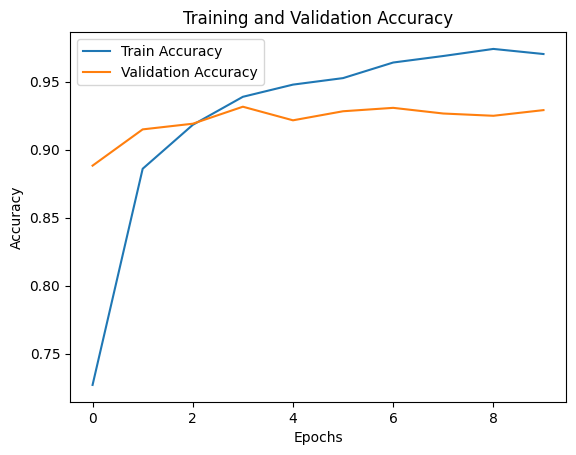

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

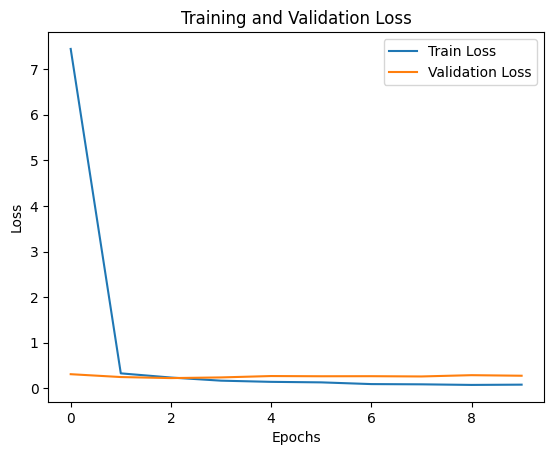

In [22]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step


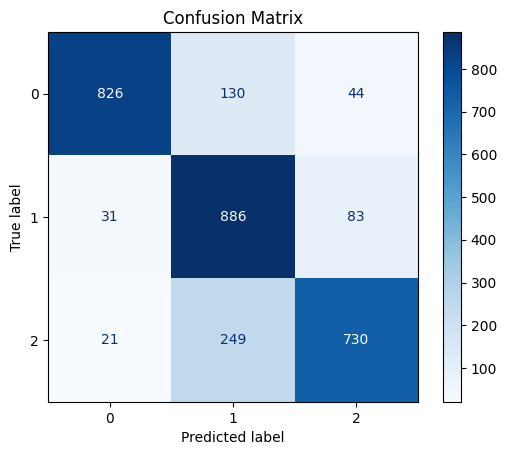

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on the test dataset
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with highest probability
y_true = np.argmax(test_labels, axis=1)  # True labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(len(cm))))

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

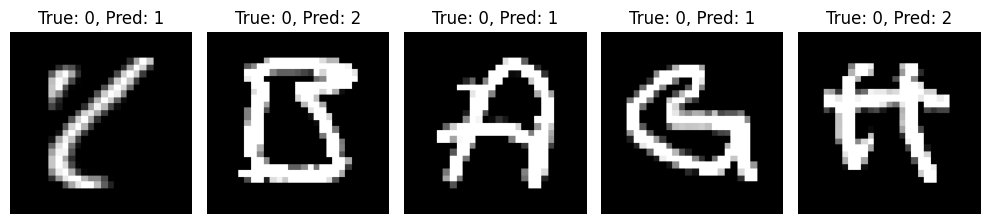

In [28]:
# Get misclassified indices
misclassified_indices = np.where(y_pred_classes != y_true)[0]

# Plot a few misclassified images
num_images_to_display = 5
plt.figure(figsize=(10, 10))
for i in range(num_images_to_display):
    index = misclassified_indices[i]
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(test_images[index].astype('uint8'))
    plt.title(f"True: {y_true[index]}, Pred: {y_pred_classes[index]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


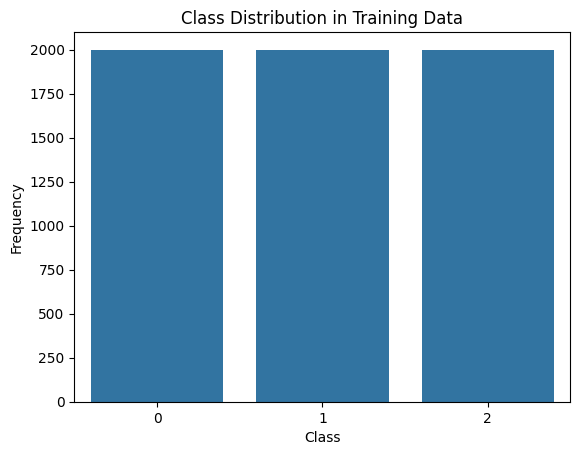

In [31]:
import seaborn as sns

# Compute class distribution
class_distribution = np.argmax(train_labels, axis=1)
sns.countplot(x=class_distribution)
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()